# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS
# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load US equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 1995
END = 2017

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10241831 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    10241831 non-null  float64
 1   high    10241831 non-null  float64
 2   low     10241831 non-null  float64
 3   close   10241831 non-null  float64
 4   volume  10241831 non-null  float64
 5   sector  10241831 non-null  object 
dtypes: float64(5), object(1)
memory usage: 508.7+ MB


In [9]:
len(prices.index.unique('ticker'))

2369

## Remove stocks with less than ten years of data

In [10]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [11]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9532628 non-null  float64
 1   high    9532628 non-null  float64
 2   low     9532628 non-null  float64
 3   close   9532628 non-null  float64
 4   volume  9532628 non-null  float64
 5   sector  9532628 non-null  object 
dtypes: float64(5), object(1)
memory usage: 473.5+ MB


In [12]:
len(prices.index.unique('ticker'))

1883

## Add some Basic Factors

### Compute the Relative Strength Index

In [13]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

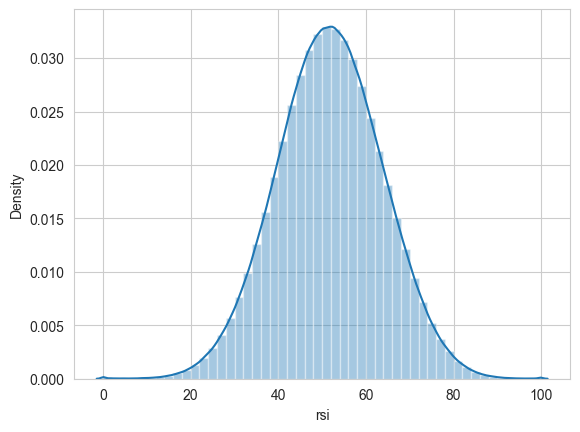

In [14]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [15]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [16]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [17]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     9532628 non-null  float64
 1   high     9532628 non-null  float64
 2   low      9532628 non-null  float64
 3   close    9532628 non-null  float64
 4   volume   9532628 non-null  float64
 5   sector   9532628 non-null  object 
 6   rsi      9506266 non-null  float64
 7   bb_high  9496851 non-null  float64
 8   bb_mid   9496851 non-null  float64
 9   bb_low   9496851 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1022.4+ MB


In [18]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,9.496851e+06,9.496851e+06,9.496851e+06
mean,2.954140e+00,2.881157e+00,2.808174e+00
std,1.024536e+00,1.026901e+00,1.032999e+00
min,8.933146e-03,8.933146e-03,-1.568426e+00
25%,2.303724e+00,2.226078e+00,2.146471e+00
50%,2.940911e+00,2.868116e+00,2.796484e+00
75%,3.555602e+00,3.487039e+00,3.420498e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


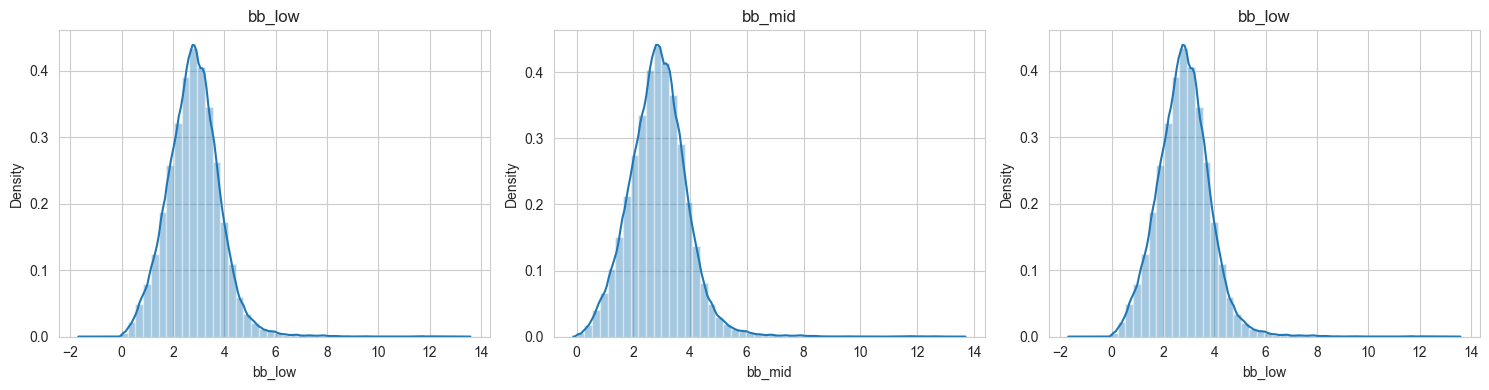

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [20]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

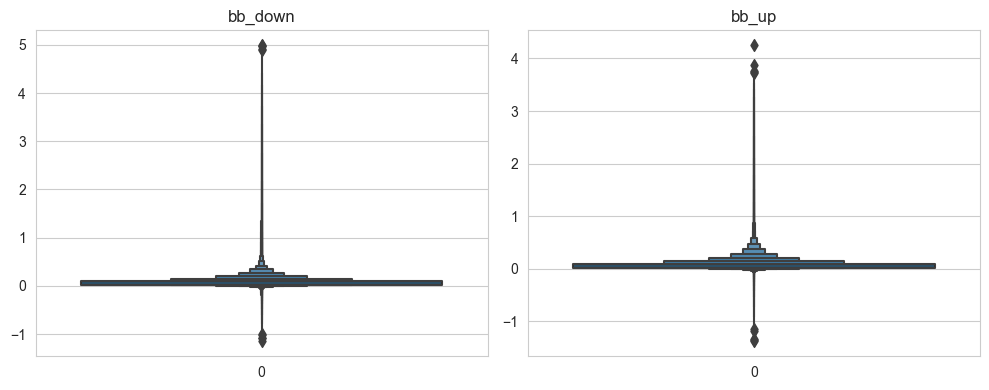

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [22]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [23]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [24]:
prices['atr'] = by_ticker.apply(compute_atr)

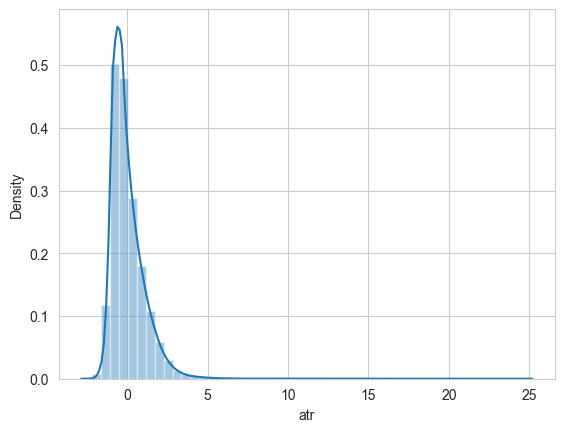

In [25]:
sns.distplot(prices.atr);

In [26]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

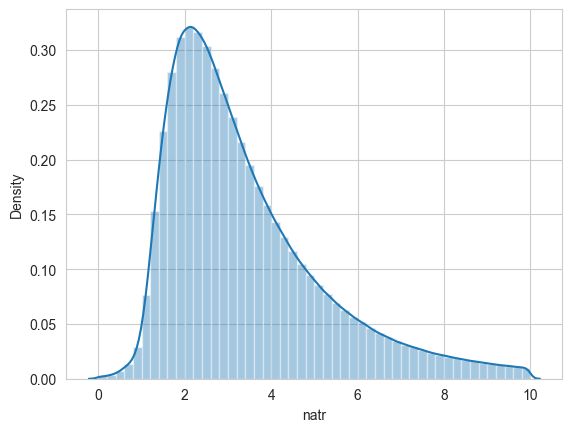

In [27]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)

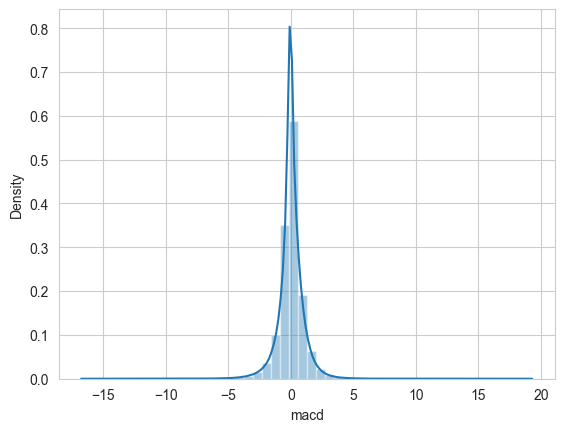

In [29]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [30]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [31]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [32]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           9532628 non-null  float64
 1   high           9532628 non-null  float64
 2   low            9532628 non-null  float64
 3   close          9532628 non-null  float64
 4   volume         9532628 non-null  float64
 5   sector         9532628 non-null  object 
 6   rsi            9506266 non-null  float64
 7   bb_high        9496851 non-null  float64
 8   bb_mid         9496851 non-null  float64
 9   bb_low         9496851 non-null  float64
 10  bb_up          9496851 non-null  float64
 11  bb_down        9496851 non-null  float64
 12  atr            9506266 non-null  float64
 13  natr           9506266 non-null  float64
 14  macd           9470489 non-null  float64
 15  dollar_volume  9532628 no

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [33]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [34]:
prices = prices.unstack('ticker')

In [35]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 452529 entries, ('AAN', Timestamp('1995-02-28 00:00:00')) to ('ORN', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  452529 non-null  float64
 1   atr            452529 non-null  float64
 2   bb_down        452529 non-null  float64
 3   bb_high        452529 non-null  float64
 4   bb_low         452529 non-null  float64
 5   bb_mid         452529 non-null  float64
 6   bb_up          452529 non-null  float64
 7   close          452529 non-null  float64
 8   macd           452529 non-null  float64
 9   natr           452529 non-null  float64
 10  rsi            452529 non-null  float64
 11  sector         452529 non-null  object 
dtypes: float64(11), object(1)
memory usage: 43.2+ MB


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [37]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

In [38]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))

data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [39]:
len(data.index.unique('ticker'))

905

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [40]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [41]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 202879 entries, ('AAPL', Timestamp('1996-02-29 00:00:00')) to ('DXCM', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   202879 non-null  float64
 1   return_3m   201069 non-null  float64
 2   return_6m   198362 non-null  float64
 3   return_12m  192972 non-null  float64
dtypes: float64(4)
memory usage: 7.0+ MB


In [42]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,202879.000000,201069.000000,198362.000000,192972.000000
mean,0.007333,0.004950,0.004345,0.004167
std,0.085992,0.050986,0.037222,0.027246
min,-0.273767,-0.179499,-0.134177,-0.093876
25%,-0.011852,-0.003188,-0.000486,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.032949,0.023727,0.018920,0.015461
max,0.331175,0.180733,0.131169,0.099726


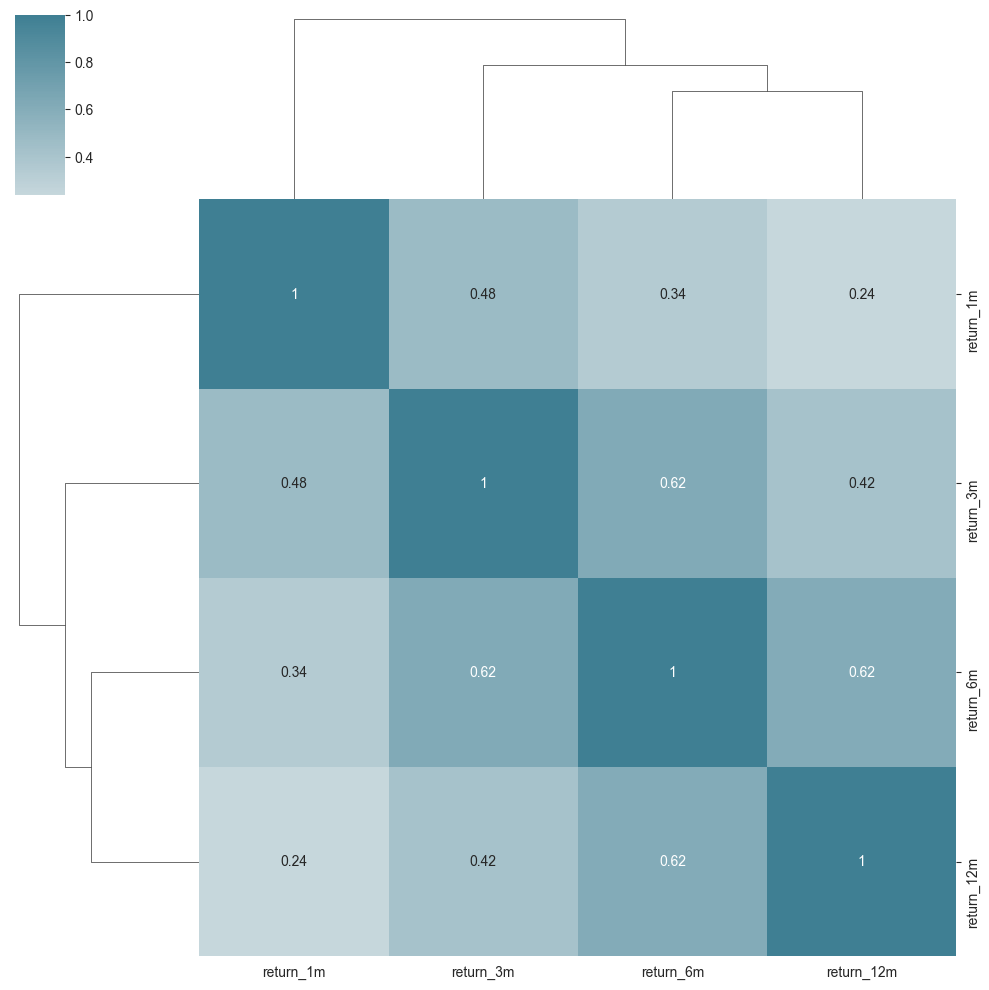

In [43]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [44]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 121589 entries, ('AAPL', Timestamp('1997-01-31 00:00:00')) to ('ULTA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   atr         121589 non-null  float64
 1   bb_down     121589 non-null  float64
 2   bb_high     121589 non-null  float64
 3   bb_low      121589 non-null  float64
 4   bb_mid      121589 non-null  float64
 5   bb_up       121589 non-null  float64
 6   macd        121589 non-null  float64
 7   natr        121589 non-null  float64
 8   rsi         121589 non-null  float64
 9   sector      121589 non-null  object 
 10  return_1m   121589 non-null  float64
 11  return_3m   121589 non-null  float64
 12  return_6m   121589 non-null  float64
 13  return_12m  121589 non-null  float64
dtypes: float64(13), object(1)
memory usage: 13.5+ MB


In [45]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [46]:
len(data.index.unique('ticker'))

613

We are left with 613 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [47]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 1995-01-31 to 2022-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  336 non-null    float64
 1   SMB     336 non-null    float64
 2   HML     336 non-null    float64
 3   RMW     336 non-null    float64
 4   CMA     336 non-null    float64
dtypes: float64(5)
memory usage: 15.8 KB


In [48]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115181 entries, ('A', Timestamp('2001-12-31 00:00:00', freq='M')) to ('ZION', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     115181 non-null  float64
 1   SMB        115181 non-null  float64
 2   HML        115181 non-null  float64
 3   RMW        115181 non-null  float64
 4   CMA        115181 non-null  float64
 5   return_1m  115181 non-null  float64
dtypes: float64(6)
memory usage: 5.8+ MB


In [49]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,115181.000000,115181.000000,115181.000000,115181.000000,115181.000000,115181.000000
mean,0.006182,0.002323,0.001869,0.003278,0.002459,0.005458
std,0.044295,0.031620,0.031330,0.029362,0.020980,0.092551
min,-0.172300,-0.153500,-0.112900,-0.187300,-0.067700,-0.387267
25%,-0.019700,-0.017000,-0.014900,-0.010700,-0.010300,-0.043905
50%,0.011700,0.001400,0.000300,0.003600,0.000100,0.002599
75%,0.034900,0.023300,0.017800,0.013900,0.014300,0.050718
max,0.113500,0.183400,0.124800,0.130900,0.090500,0.503475


In [50]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [51]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79014.000000,79014.000000,79014.000000,79014.000000,79014.000000,115181.000000
mean,0.066598,0.188690,0.117499,-0.018827,0.009469,0.249311
std,0.480192,0.586571,0.819292,0.878633,0.968533,1.384270
min,-1.841482,-1.995921,-4.042187,-5.201273,-5.129024,-10.004624
25%,-0.257038,-0.206762,-0.414350,-0.495432,-0.543025,-0.143136
50%,0.044411,0.147280,0.062184,0.044655,0.058279,0.000000
75%,0.370229,0.544048,0.603386,0.537252,0.603451,0.838997
max,2.739554,3.314653,4.759474,4.036887,5.085621,10.772196


In [52]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79014.000000,79014.000000,79014.000000,79014.000000,79014.000000,115181.000000
mean,0.066598,0.188690,0.117499,-0.018827,0.009469,0.249311
std,0.480192,0.586571,0.819292,0.878633,0.968533,1.384270
min,-1.841482,-1.995921,-4.042187,-5.201273,-5.129024,-10.004624
25%,-0.257038,-0.206762,-0.414350,-0.495432,-0.543025,-0.143136
50%,0.044411,0.147280,0.062184,0.044655,0.058279,0.000000
75%,0.370229,0.544048,0.603386,0.537252,0.603451,0.838997
max,2.739554,3.314653,4.759474,4.036887,5.085621,10.772196


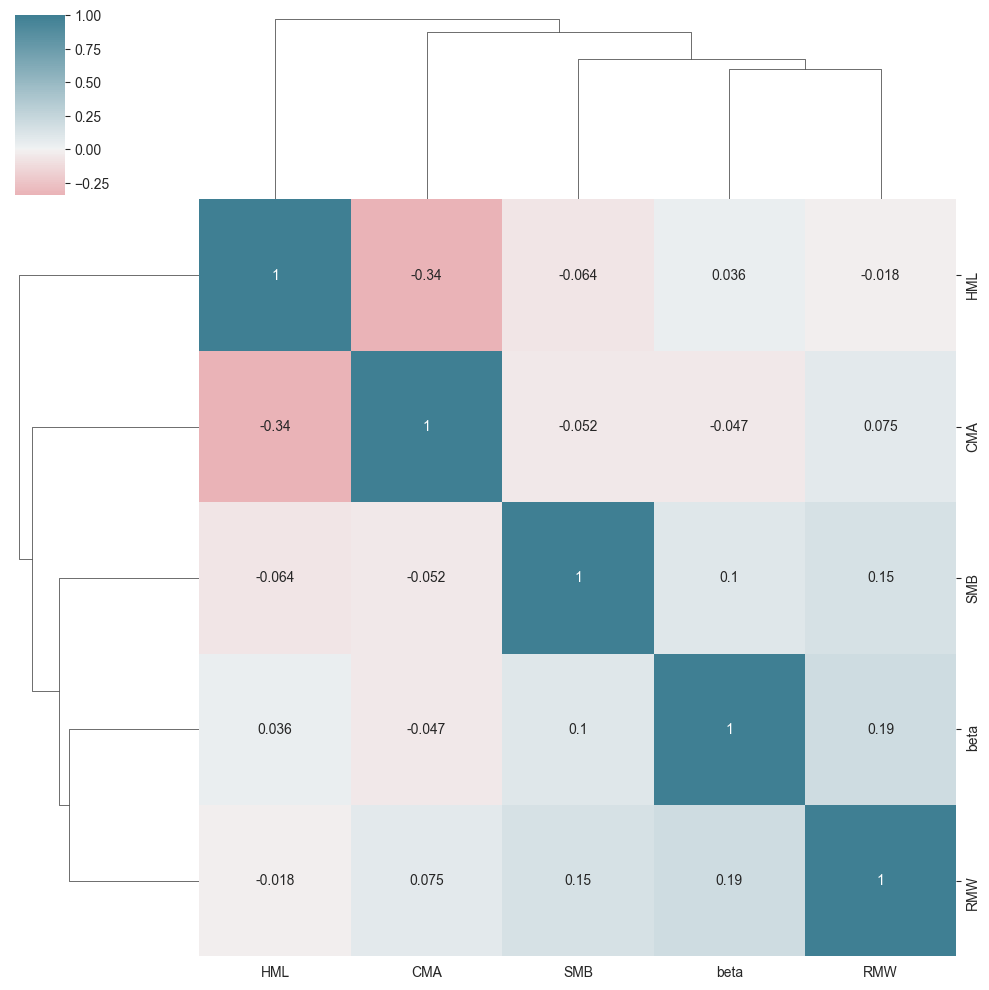

In [53]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [54]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78401 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         78401 non-null  float64
 1   bb_down     78401 non-null  float64
 2   bb_high     78401 non-null  float64
 3   bb_low      78401 non-null  float64
 4   bb_mid      78401 non-null  float64
 5   bb_up       78401 non-null  float64
 6   macd        78401 non-null  float64
 7   natr        78401 non-null  float64
 8   rsi         78401 non-null  float64
 9   sector      78401 non-null  object 
 10  return_1m   78401 non-null  float64
 11  return_3m   78401 non-null  float64
 12  return_6m   78401 non-null  float64
 13  return_12m  78401 non-null  float64
 14  beta        78401 non-null  float64
 15  SMB         78401 non-null  float64
 16  HML         78401 non-null  float64
 17  RMW         78401 non-null  floa

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [56]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [57]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [58]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [59]:
data = data.dropna()

In [60]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

## Sector Breakdown

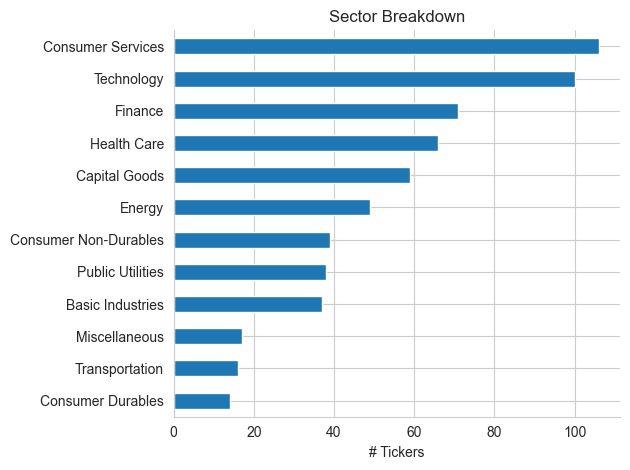

In [61]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [62]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)

## Evaluate mutual information

In [63]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [64]:
mi = mutual_info_regression(X=X, y=data.target)

In [65]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr             0.111766
return_12m       0.060058
return_6m        0.054057
year             0.049789
return_3m        0.047010
momentum_3_12    0.040166
momentum_3_6     0.038066
bb_up            0.035927
momentum_12      0.035711
return_1m        0.035045
dtype: float64

In [66]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [67]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

year          0.009372
month         0.006986
return_6m     0.005161
atr           0.005069
rsi           0.004230
return_12m    0.003147
beta          0.002146
natr          0.001928
sector        0.001873
return_1m     0.001860
dtype: float64

In [68]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [69]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

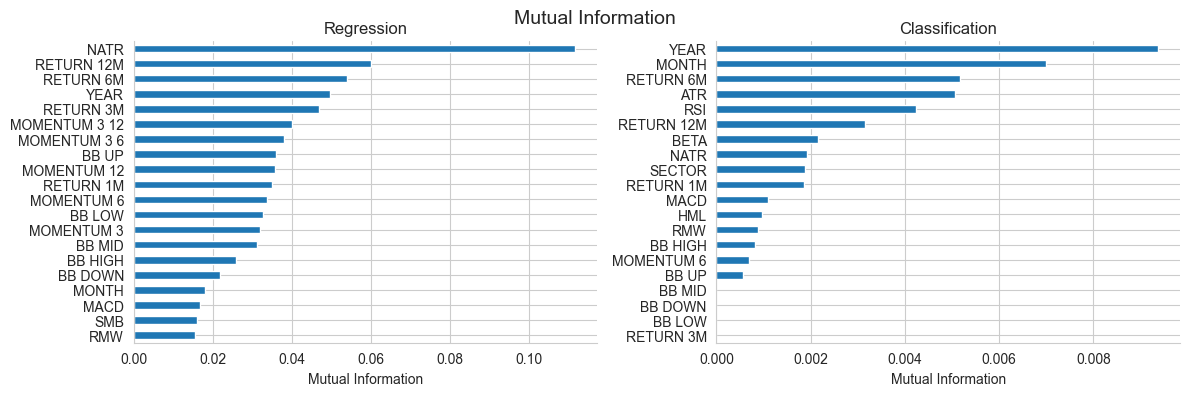

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)